In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

#Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
news = pd.read_excel('drive/My Drive/Colab Notebooks/data/Combined_News_DJIA.xls')

print(news.isnull().values.any())

print(news.shape)

False
(1989, 27)


In [4]:
news.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into So...,'Russian tanks are moving towards the capital...,"""Afghan children raped with 'impunity,' U.N. ...",'150 Russian tanks have entered South Ossetia...,"""Breaking: Georgia invades South Ossetia, Rus...","""The 'enemy combatent' trials are nothing but...",'Georgian troops retreat from S. Osettain cap...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack ...,'Announcing:Class Action Lawsuit on Behalf of...,"""So---Russia and Georgia are at war and the N...","""China tells Bush to stay out of other countr...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia ge...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to p...",'This is a busy day: The European Union has ...,"""Georgia will withdraw 1,000 soldiers from Ir...",'Why the Pentagon Thinks Attacking Iran is a ...,'Caucasus in crisis: Georgia invades South Os...,'Indian shoe manufactory - And again in a se...,'Visitors Suffering from Mental Illnesses Ban...,"""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,'Why wont America and Nato help us? If they w...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli ...",'Georgian army flees in disarray as Russians ...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zea...,'Russia angered by Israeli military sale to G...,'An American citizen living in S.Ossetia blam...,'Welcome To World War IV! Now In High Definit...,"""Georgia's move, a mistake of monumental prop...",'Russia presses deeper into Georgia; U.S. say...,'Abhinav Bindra wins first ever Individual Ol...,' U.S. ship heads for Arctic to define territ...,'Drivers in a Jerusalem taxi station threaten...,'The French Team is Stunned by Phelps and the...,'Israel and the US behind the Georgian aggres...,"'""Do not believe TV, neither Russian nor Geor...",'Riots are still going on in Montreal (Canada...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Tort...,' Russia has just beaten the United States ov...,'Perhaps *the* question about the Georgia - R...,'Russia is so much better at war',"""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,'Remember that adorable 9-year-old who sang a...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would hav...","""Al-Qa'eda is losing support in Iraq because ...",'Ceasefire in Georgia: Putin Outmaneuvers the...,'Why Microsoft and Intel tried to kill the XO...,'Stratfor: The Russo-Georgian War and the Bal...,"""I'm Trying to Get a Sense of This Whole Geor...","""The US military was surprised by the timing ...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the S...",'CNN use footage of Tskhinvali ruins to cover...,'Beginning a war as the Olympics were opening...,'55 pyramids as large as the Luxor stacked in...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know t...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious ...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led y...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgi...,'Christopher King argues that the US and NATO...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man..."


In [5]:
news['text'] = news['Top1'] +  news['Top2'] + news['Top3'] + news['Top4'] + news['Top5'] + news['Top6'] + news['Top7'] + news['Top8'] + news['Top9'] + news['Top10'] + news['Top11'] + news['Top12'] + news['Top13'] + news['Top14'] + news['Top15'] + news['Top16'] + news['Top17'] + news['Top18'] + news['Top19'] + news['Top20'] + news['Top21'] + news['Top22'] + news['Top23'] + news['Top24'] + news['Top25']

In [6]:
train = news[news['Date'] < '20150101']
test = news[news['Date'] > '20141231']

In [7]:
news['text'] = news['text'].apply(str)

In [8]:
train['text'] = train['text'].apply(str)
test['text'] = test['text'].apply(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#Data Cleaning

In [9]:
#Function to preprocess each review
    # 'r' is used to differentiate regex escaping and normal escape sequence 
def preprocess(sen):
    # Function to remove html tags is called
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    # '^' means NOT
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

# Function to remove html tags
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

In [10]:
X_train = []
sentences = list(train['text'])
for sen in sentences:
    X_train.append(preprocess(sen))

In [11]:
X_test = []
sentences = list(train['text'])
for sen in sentences:
    X_test.append(preprocess(sen))

In [12]:
X = []
sentences = list(news['text'])
for sen in sentences:
    X.append(preprocess(sen))

In [13]:
X[1]

' Why wont America and Nato help us If they wont help us now why did we help them in Iraq Bush puts foot down on Georgian conflict Jewish Georgian minister Thanks to Israeli training we re fending off Russia Georgian army flees in disarray as Russians advance Gori abandoned to Russia without shot fired Olympic opening ceremony fireworks faked What were the Mossad with fraudulent New Zealand Passports doing in Iraq Russia angered by Israeli military sale to Georgia An American citizen living in Ossetia blames S and Georgian leaders for the genocide of innocent people Welcome To World War IV Now In High Definition Georgia move mistake of monumental proportions Russia presses deeper into Georgia S says regime change is goal Abhinav Bindra wins first ever Individual Olympic Gold Medal for India S ship heads for Arctic to define territory Drivers in Jerusalem taxi station threaten to quit rather than work for their new boss an Arab The French Team is Stunned by Phelps and the m Relay Team I

In [14]:
y_train = np.array(train['Label'])
y_test = np.array(test['Label'])

In [15]:
y = np.array(news['Label'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Embedding

In [17]:
# Preparing the Embedding Layer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [18]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [19]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('drive/My Drive/Colab Notebooks/data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# CNN

In [21]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [22]:
#CNN 1Dx2
model1 = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False),
      tf.keras.layers.Conv1D(128, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv1D(64, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['acc'])

In [23]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          4551600   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 64)            0

In [24]:
history = model1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model1.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
10/10 [==============================] - 8s 93ms/step - loss: 0.8709 - acc: 0.4798 - val_loss: 0.7250 - val_acc: 0.4577
Epoch 2/6
10/10 [==============================] - 0s 10ms/step - loss: 0.6916 - acc: 0.5267 - val_loss: 0.6946 - val_acc: 0.4953
Epoch 3/6
10/10 [==============================] - 0s 10ms/step - loss: 0.6867 - acc: 0.5432 - val_loss: 0.7072 - val_acc: 0.4577
Epoch 4/6
10/10 [==============================] - 0s 10ms/step - loss: 0.6847 - acc: 0.5524 - val_loss: 0.6991 - val_acc: 0.4639
Epoch 5/6
10/10 [==============================] - 0s 9ms/step - loss: 0.6775 - acc: 0.5795 - val_loss: 0.6978 - val_acc: 0.4859
Epoch 6/6
13/13 [==============================] - 0s 6ms/step - loss: 0.6841 - acc: 0.5754


In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6841418147087097
Test Accuracy: 0.5753768682479858


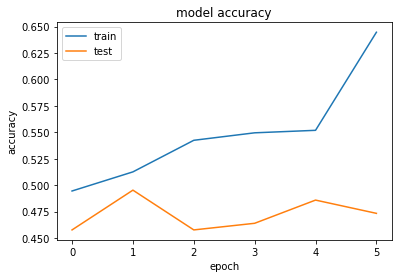

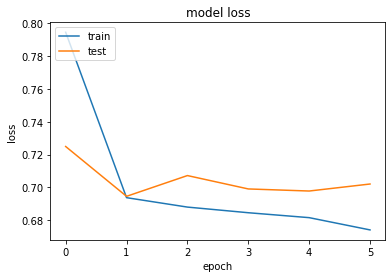

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#LSTM


In [27]:
# LSTM 
model2 = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False),
      tf.keras.layers.LSTM(128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      #tf.keras.layers.LSTM(128, activation='relu'),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [28]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          4551600   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 64)            0

In [29]:
history = model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model2.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
10/10 [==============================] - 3s 192ms/step - loss: 0.6964 - acc: 0.4928 - val_loss: 0.7144 - val_acc: 0.4577
Epoch 2/6
10/10 [==============================] - 2s 166ms/step - loss: 0.6912 - acc: 0.5267 - val_loss: 0.7099 - val_acc: 0.4577
Epoch 3/6
10/10 [==============================] - 2s 165ms/step - loss: 0.6849 - acc: 0.5428 - val_loss: 0.7129 - val_acc: 0.4608
Epoch 4/6
10/10 [==============================] - 2s 176ms/step - loss: 0.6776 - acc: 0.5549 - val_loss: 0.7333 - val_acc: 0.4734
Epoch 5/6
10/10 [==============================] - 2s 160ms/step - loss: 0.6648 - acc: 0.6002 - val_loss: 0.7096 - val_acc: 0.4765
Epoch 6/6
13/13 [==============================] - 0s 16ms/step - loss: 0.6968 - acc: 0.5302


In [30]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.696770966053009
Test Accuracy: 0.5301507711410522


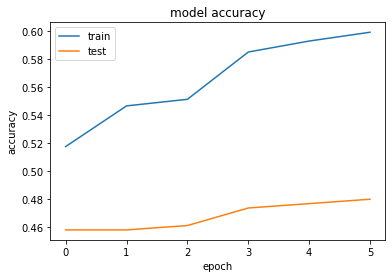

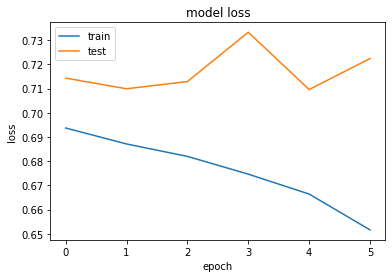

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#CNN +LSTM

In [32]:
# CNN + LSTM 
model3 = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False),
      tf.keras.layers.Conv1D(128, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Reshape((48,128), input_shape=(48,128)),
      tf.keras.layers.LSTM(128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      #tf.keras.layers.Conv1D(64, 5, activation='relu'),
      #tf.keras.layers.MaxPooling1D(2),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          4551600   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
reshape (Reshape)            (None, 48, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [33]:
history = model3.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model3.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
10/10 [==============================] - 3s 126ms/step - loss: 0.6942 - acc: 0.5235 - val_loss: 0.6988 - val_acc: 0.4577
Epoch 2/6
10/10 [==============================] - 1s 93ms/step - loss: 0.6922 - acc: 0.5327 - val_loss: 0.7084 - val_acc: 0.4577
Epoch 3/6
10/10 [==============================] - 1s 92ms/step - loss: 0.6834 - acc: 0.5547 - val_loss: 0.6977 - val_acc: 0.5016
Epoch 4/6
10/10 [==============================] - 1s 100ms/step - loss: 0.6864 - acc: 0.5490 - val_loss: 0.7094 - val_acc: 0.4639
Epoch 5/6
10/10 [==============================] - 1s 90ms/step - loss: 0.6738 - acc: 0.5837 - val_loss: 0.7228 - val_acc: 0.4577
Epoch 6/6
13/13 [==============================] - 0s 9ms/step - loss: 0.7119 - acc: 0.5025


In [34]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7119483351707458
Test Accuracy: 0.5025125741958618


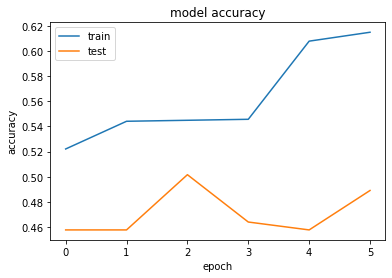

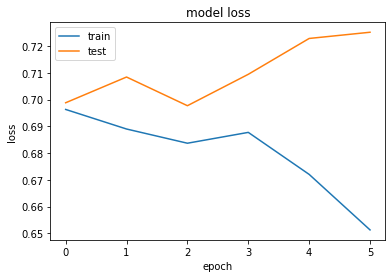

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# simple 2D CNN

In [44]:
# simple 2D CNN
model5 = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False),
      tf.keras.layers.Reshape((100,10,10), input_shape=(100,100)),
      tf.keras.layers.Conv2D(128, (5,5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      #tf.keras.layers.Dropout(0.2),
      #tf.keras.layers.Reshape((48,128), input_shape=(48,128)),
      #tf.keras.layers.LSTM(128, activation='relu'),
      #tf.keras.layers.Dropout(0.1),
      #tf.keras.layers.Conv1D(64, 5, activation='relu'),
      #tf.keras.layers.MaxPooling1D(2),
      #tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model5.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          4551600   
_________________________________________________________________
reshape_6 (Reshape)          (None, 100, 10, 10)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 6, 128)        32128     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 3, 128)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dense_19 (Dense)             (None, 64)               

In [45]:
print(model5.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          4551600   
_________________________________________________________________
reshape_6 (Reshape)          (None, 100, 10, 10)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 6, 128)        32128     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 3, 128)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dense_19 (Dense)             (None, 64)               

In [46]:
history = model5.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model5.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
10/10 [==============================] - 1s 43ms/step - loss: 1.8311 - acc: 0.4904 - val_loss: 0.7314 - val_acc: 0.4577
Epoch 2/6
10/10 [==============================] - 0s 12ms/step - loss: 0.7003 - acc: 0.4983 - val_loss: 0.7279 - val_acc: 0.4577
Epoch 3/6
10/10 [==============================] - 0s 11ms/step - loss: 0.6861 - acc: 0.5521 - val_loss: 0.7299 - val_acc: 0.4577
Epoch 4/6
10/10 [==============================] - 0s 12ms/step - loss: 0.6684 - acc: 0.5570 - val_loss: 0.7006 - val_acc: 0.4639
Epoch 5/6
10/10 [==============================] - 0s 11ms/step - loss: 0.6591 - acc: 0.6230 - val_loss: 0.7187 - val_acc: 0.4577
Epoch 6/6
13/13 [==============================] - 0s 4ms/step - loss: 0.6950 - acc: 0.4824


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6903513073921204
Test Accuracy: 0.570351779460907


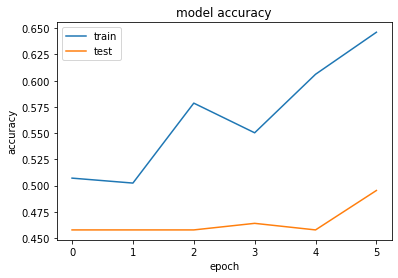

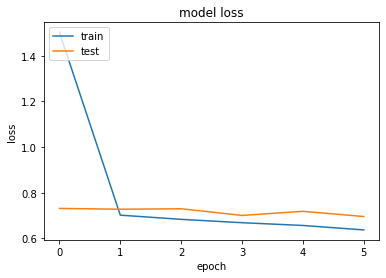

In [47]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#2D CNN +LSTM


In [40]:
# CNN 2D
model4 = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False),
      tf.keras.layers.Reshape((100,10,10), input_shape=(100,100)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Reshape((128,98), input_shape=(49,4,64)),
      tf.keras.layers.LSTM((128), activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          4551600   
_________________________________________________________________
reshape_3 (Reshape)          (None, 100, 10, 10)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 8, 64)         5824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 4, 64)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 49, 4, 64)         0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 128, 98)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)              

In [37]:
history = model4.fit(X_train, y_train, batch_size=128, epochs=10, verbose=2, validation_split=0.2)

score = model4.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
10/10 - 4s - loss: 0.6923 - acc: 0.5346 - val_loss: 0.6978 - val_acc: 0.4577
Epoch 2/10
10/10 - 2s - loss: 0.6898 - acc: 0.5425 - val_loss: 0.7157 - val_acc: 0.4577
Epoch 3/10
10/10 - 2s - loss: 0.6896 - acc: 0.5440 - val_loss: 0.7048 - val_acc: 0.4577
Epoch 4/10
10/10 - 2s - loss: 0.6898 - acc: 0.5487 - val_loss: 0.7004 - val_acc: 0.4577
Epoch 5/10
10/10 - 2s - loss: 0.6881 - acc: 0.5448 - val_loss: 0.7053 - val_acc: 0.4577
Epoch 6/10
10/10 - 2s - loss: 0.6859 - acc: 0.5409 - val_loss: 0.6992 - val_acc: 0.4577
Epoch 7/10
10/10 - 2s - loss: 0.6848 - acc: 0.5417 - val_loss: 0.6986 - val_acc: 0.4514
Epoch 8/10
10/10 - 2s - loss: 0.6787 - acc: 0.5708 - val_loss: 0.7338 - val_acc: 0.4577
Epoch 9/10
10/10 - 2s - loss: 0.6846 - acc: 0.5503 - val_loss: 0.7361 - val_acc: 0.4577
Epoch 10/10
10/10 - 2s - loss: 0.6750 - acc: 0.5747 - val_loss: 0.6977 - val_acc: 0.4765
13/13 [==============================] - 0s 20ms/step - loss: 0.6989 - acc: 0.4422


In [38]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6989283561706543
Test Accuracy: 0.4422110617160797


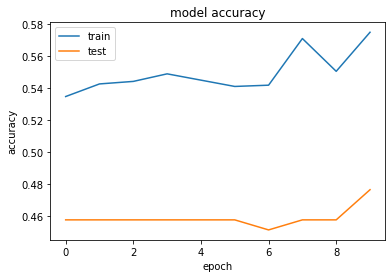

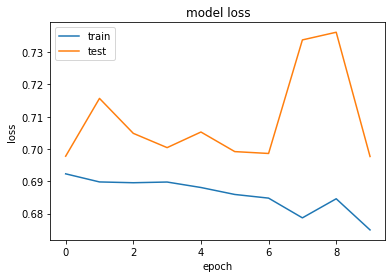

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()